In [35]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.rand(5,3)

tensor([[0.4886, 0.4983, 0.2158],
        [0.9831, 0.5560, 0.2534],
        [0.4004, 0.3867, 0.7440],
        [0.1816, 0.1374, 0.4762],
        [0.5898, 0.2154, 0.8166]])

In [3]:
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

/opt/homebrew/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size = 32
train_dl = DataLoader(train, batch_size=batch_size)
test_dl = DataLoader(test, batch_size=batch_size)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [76]:
for X, y in test_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [144]:
class NN(nn.Module):
    def __init__(self, activ=None):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 100),
            activ(),
            nn.Linear(100, 100),
            activ(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits


In [150]:
models = [NN(nn.ReLU).to(device), NN(nn.Sigmoid).to(device)]
optims = [torch.optim.SGD(m.parameters(), lr=1e-3) for m in models]
models

[NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (model): Sequential(
     (0): Linear(in_features=784, out_features=100, bias=True)
     (1): ReLU()
     (2): Linear(in_features=100, out_features=100, bias=True)
     (3): ReLU()
     (4): Linear(in_features=100, out_features=10, bias=True)
   )
 ),
 NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (model): Sequential(
     (0): Linear(in_features=784, out_features=100, bias=True)
     (1): Sigmoid()
     (2): Linear(in_features=100, out_features=100, bias=True)
     (3): Sigmoid()
     (4): Linear(in_features=100, out_features=10, bias=True)
   )
 )]

Epoch 1
-------------------------------
loss: 2.289914  [    0/60000]
loss: 2.284118  [ 3200/60000]
loss: 2.266824  [ 6400/60000]
loss: 2.281034  [ 9600/60000]
loss: 2.262739  [12800/60000]
loss: 2.286728  [16000/60000]
loss: 2.276735  [19200/60000]
loss: 2.223109  [22400/60000]
loss: 2.217638  [25600/60000]
loss: 2.231149  [28800/60000]
loss: 2.200844  [32000/60000]
loss: 2.203092  [35200/60000]
loss: 2.226351  [38400/60000]
loss: 2.208076  [41600/60000]
loss: 2.145327  [44800/60000]
loss: 2.172478  [48000/60000]
loss: 2.164041  [51200/60000]
loss: 2.134209  [54400/60000]
loss: 2.063841  [57600/60000]
Epoch 2
-------------------------------
loss: 2.032917  [    0/60000]
loss: 2.096742  [ 3200/60000]
loss: 2.031110  [ 6400/60000]
loss: 2.029968  [ 9600/60000]
loss: 1.987978  [12800/60000]
loss: 2.043529  [16000/60000]
loss: 1.910532  [19200/60000]
loss: 1.841567  [22400/60000]
loss: 1.838423  [25600/60000]
loss: 1.826014  [28800/60000]
loss: 1.687403  [32000/60000]
loss: 1.636662  [352

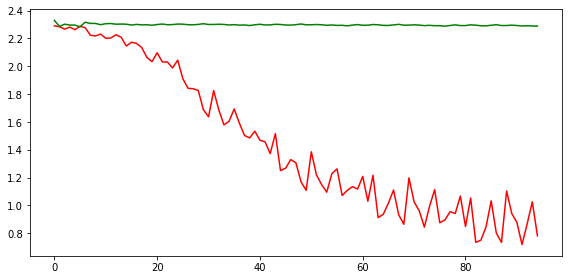

In [151]:
plt.figure(figsize=(8,4))
losses = [[], []]
size = len(train_dl.dataset)
epochs = 5
# for mi in range(len(models)):
for mi in [0, 1]:
    loss_fn = nn.CrossEntropyLoss()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        models[mi].train()
        for batch, (X, y) in enumerate(train_dl):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = models[mi](X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optims[mi].zero_grad()
            loss.backward()
            optims[mi].step()


            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                losses[mi].append(loss)


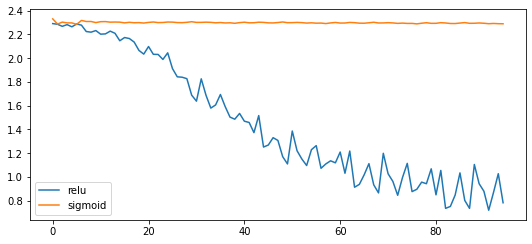

(2, 95)

In [157]:
plt.plot(losses[0], label='relu')
plt.plot(losses[1], label='sigmoid')
plt.legend()
plt.show()
np.array(losses).shape

TODO: Same test with number MNIST